In [41]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


# Data Cleaning

In [42]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [43]:
print(df.columns)
print(type(df.Salary[0]))
print(type(df['Years of Experience'][0]))

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
<class 'numpy.float64'>
<class 'numpy.float64'>


In [44]:
# Combining the education level Bachelor's degree and Bachelor's
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

Text(0, 0.5, 'Salary')

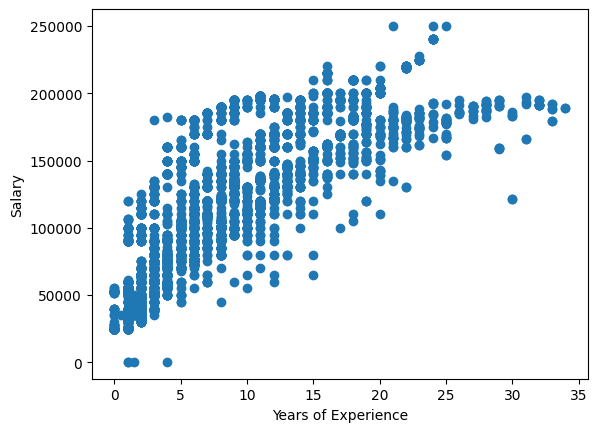

In [45]:
plt.scatter(df['Years of Experience'], df['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_24200/551786710.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

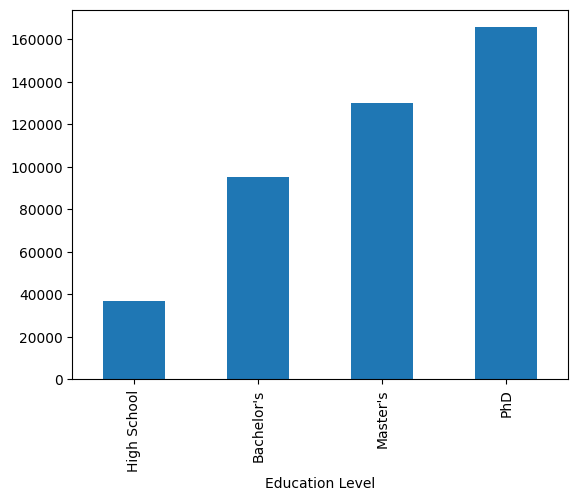

In [46]:
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [47]:
# Job Title with the most data
df['Job Title'].value_counts()

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Supply Chain Analyst            1
Name: count, Length: 193, dtype: int64

In [48]:
# Remove Jobs with less than 10 data points
df = df.groupby('Job Title').filter(lambda x: len(x) > 100)
df['Job Title'].value_counts()

Job Title
Software Engineer            518
Data Scientist               453
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          309
Marketing Manager            255
Senior Software Engineer     244
Back end Developer           244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Name: count, dtype: int64

# Prepare data

In [49]:
df.columns

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')

In [89]:
target_column = "Salary"
sensitive_feature = ['Age', 'Gender']
features = df.columns.difference([target_column])

df = df.dropna(subset=df.columns).copy()
df = df[df['Gender'] != 'Other']
df_prep= df.copy()

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_prep['Education Level'] = df_prep['Education Level'].map(lambda x: education_mapping.get(x, x)).copy()

gender_mapping = {'Male': 0, 'Female': 1}
df_prep['Gender'] = df_prep['Gender'].map(lambda x: gender_mapping.get(x, x)).copy()

train, test = train_test_split(df_prep, test_size=0.4, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

scaler = StandardScaler()

train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

encoder = LabelEncoder()
train['Job Title'] = encoder.fit_transform(train['Job Title'])
val['Job Title'] = encoder.transform(val['Job Title'])
test['Job Title'] = encoder.transform(test['Job Title'])

X_train = pd.DataFrame((train),columns = features)
y_train = pd.DataFrame((train),columns = [target_column])
X_val = pd.DataFrame((val),columns = features)
y_val = pd.DataFrame((val),columns = [target_column])
X_test = pd.DataFrame((test),columns = features)
y_test = pd.DataFrame((test),columns = [target_column])

In [90]:
X_train

,Age,Education Level,Gender,Job Title,Years of Experience
1361,1.156810,3,0,13,0.733624
5793,0.647008,1,1,3,1.217611
566,-1.137299,1,1,1,-1.040997
2772,-0.500047,1,1,16,-0.557009
5852,-0.627497,1,0,8,-0.718338
...,...,...,...,...,...
3655,-0.117695,1,0,11,-0.395680
4154,1.156810,2,1,6,0.894953
1897,-0.754948,1,0,4,-1.040997
5895,-0.882398,1,0,16,-0.879667


# Training For Data Scientist Job not important for prediction

In [91]:
selected_features = ['Years of Experience', 'Education Level', 'Job Title']
model_all = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000)
model_all.fit(X_train[selected_features], y_train[target_column])

y_pred = model_all.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    np.concatenate((X_test[['Years of Experience']].values, y_pred.reshape(-1, 1), X_test[['Age']].values), axis=1))[:, 1]

sum_error_all = 0

for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_all}")

Mean Squared Error: 0.15838870807558594
Average Error: 14053.483453784771


# Including Gender & Age

In [92]:
selected_features = ['Years of Experience', 'Education Level', 'Age', 'Gender', 'Job Title']
model_all_gen = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000)
model_all_gen.fit(X_train[selected_features], y_train[target_column])

y_pred = model_all_gen.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    np.concatenate((X_test[['Years of Experience']].values, y_pred.reshape(-1, 1), X_test[['Age']].values), axis=1))[:, 1]

sum_error_all = 0

for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_all}")

Mean Squared Error: 0.119910954516468
Average Error: 11624.434968640886


Test loss 0.18

# Prepare Data For Software Engineer

In [74]:
df_job = df_prep[df_prep['Job Title'] == 'Software Engineer']

train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

scaler = StandardScaler()

train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

encoder = LabelEncoder()
train['Job Title'] = encoder.fit_transform(train['Job Title'])
val['Job Title'] = encoder.transform(val['Job Title'])
test['Job Title'] = encoder.transform(test['Job Title'])

X_train = pd.DataFrame((train),columns = features)
y_train = pd.DataFrame((train),columns = [target_column])
X_val = pd.DataFrame((val),columns = features)
y_val = pd.DataFrame((val),columns = [target_column])
X_test = pd.DataFrame((test),columns = features)
y_test = pd.DataFrame((test),columns = [target_column])

# Training For Software Engineer Job

In [75]:
selected_features = ['Years of Experience', 'Education Level']
model_SE = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000)
model_SE.fit(X_train[selected_features], y_train[target_column])

y_pred = model_SE.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    np.concatenate((X_test[['Years of Experience']].values, y_pred.reshape(-1, 1), X_test[['Age']].values), axis=1))[:, 1]

sum_error_all = 0

for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_all}")

Mean Squared Error: 0.2977444650533928
Average Error: 19942.42728998102


# Including Gender & Age

In [76]:
selected_features = ['Years of Experience', 'Education Level', 'Age' ,'Gender']
model_SE_gen = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000)
model_SE_gen.fit(X_train[selected_features], y_train[target_column])

y_pred = model_SE_gen.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    np.concatenate((X_test[['Years of Experience']].values, y_pred.reshape(-1, 1), X_test[['Age']].values), axis=1))[:, 1]

sum_error_all = 0

for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_all}")

Mean Squared Error: 0.09621591027091397
Average Error: 8336.13108461134


## Define Feature importance ALL JOBS

In [57]:
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
5,29.0,Male,Bachelor's,Marketing Analyst,2.0,55000.0
6,42.0,Female,Master's,Product Manager,12.0,120000.0
8,26.0,Female,Bachelor's,Marketing Coordinator,1.0,45000.0
...,...,...,...,...,...,...
6682,28.0,Male,PhD,Marketing Manager,4.0,55000.0
6690,42.0,Male,Bachelor's,Financial Manager,13.0,130000.0
6691,36.0,Female,PhD,Marketing Manager,9.0,95000.0
6701,30.0,Female,Bachelor's,Financial Manager,4.0,55000.0


/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_24200/3403529775.py:17: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(X_permuted.iloc[:, col].values)
/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_24200/3403529775.py:17: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(X_permuted.iloc[:, col].values)
/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_24200/3403529775.py:17: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tenso

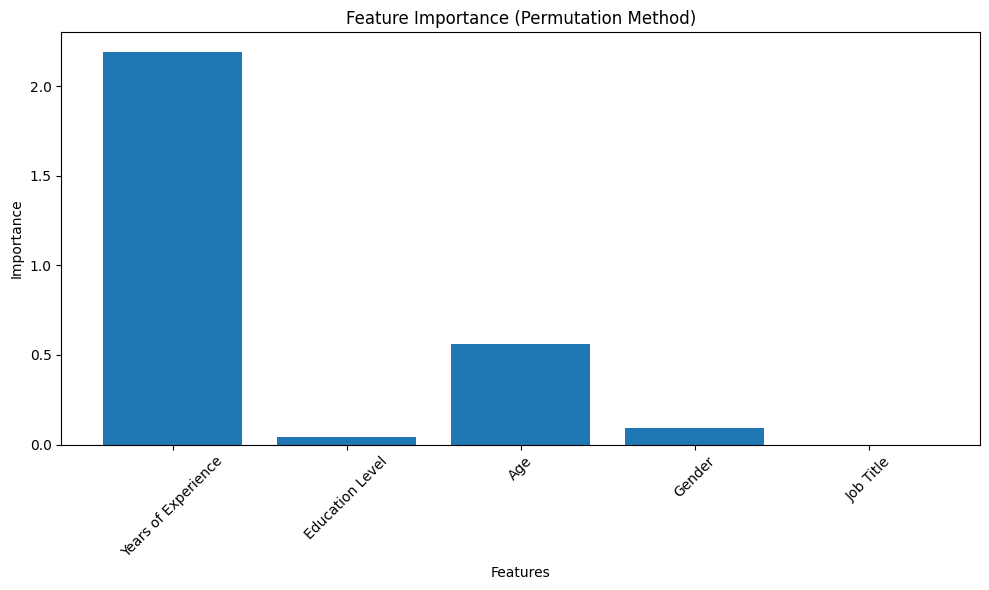

Years of Experience: 2.1900
Education Level: 0.0445
Age: 0.5621
Gender: 0.0909
Job Title: 0.0000


In [77]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def permutation_importance(model, X, y, n_repeats=10):
    # Calculate the baseline mean squared error
    baseline_mse = mean_squared_error(y, model.predict(X))
    importances = []

    # Loop over each feature
    for col in range(X.shape[1]):
        feature_importances = []
        for _ in range(n_repeats):
            # Copy the data to avoid modifying the original dataset
            X_permuted = X.copy(deep=True)
            # Permute the values in the specific column
            np.random.shuffle(X_permuted.iloc[:, col].values)
            # Calculate the new MSE with the permuted column
            permuted_mse = mean_squared_error(y, model.predict(X_permuted))
            # The importance is the increase in MSE
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        # Average the importance over the repeats for stability
        importances.append(np.mean(feature_importances))

    return np.array(importances)

# Calculate permutation importance
selected_features = ['Years of Experience', 'Education Level', 'Age', 'Gender']
feature_names = selected_features
importances = permutation_importance(model_all_gen, X_test[selected_features], y_test.values.ravel())

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importances
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")


It's important to note that these values represent the increase in the model's error when the feature is permuted. A larger increase in error indicates that the feature is more important for the model's predictions

/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_24200/3106533150.py:17: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(X_permuted.iloc[:, col].values)
/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_24200/3106533150.py:17: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(X_permuted.iloc[:, col].values)
/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_24200/3106533150.py:17: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tenso

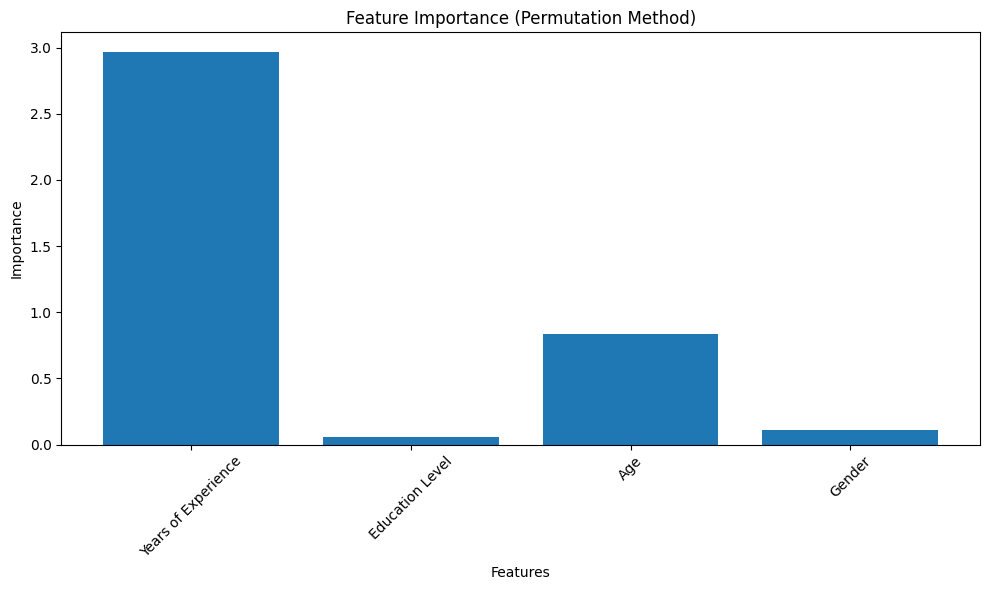

Years of Experience: 2.9672
Education Level: 0.0554
Age: 0.8375
Gender: 0.1077


In [67]:
# Calculate permutation importance
selected_features = ['Years of Experience', 'Education Level', 'Age', 'Gender']
feature_names = selected_features
importances = permutation_importance(model_SE_gen, X_test[selected_features], y_test.values.ravel())

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importances
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

# Fairness

In [93]:
# Separate the data by gender
salaries_men = df[df['Gender'] == 'Male']['Salary']
salaries_women = df[df['Gender'] == 'Female']['Salary']

# Calculate the mean salaries
mean_salary_men = salaries_men.mean()
mean_salary_women = salaries_women.mean()

mean_salary_men, mean_salary_women

(129414.41940532082, 119114.12423935092)

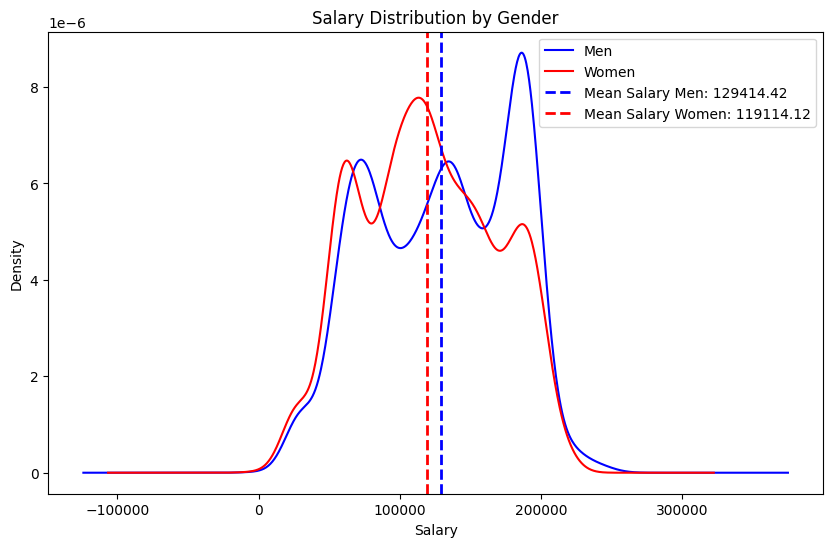

In [94]:
# Separate the data by gender
salaries_men = df[df['Gender'] == 'Male']['Salary']
salaries_women = df[df['Gender'] == 'Female']['Salary']

# Calculate the mean salaries
mean_salary_men = salaries_men.mean()
mean_salary_women = salaries_women.mean()

# Create the plot
plt.figure(figsize=(10, 6))
salaries_men.plot(kind='density', label='Men', color='blue')
salaries_women.plot(kind='density', label='Women', color='red')

# Add vertical lines for the mean salaries
plt.axvline(mean_salary_men, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Salary Men: {mean_salary_men:.2f}')
plt.axvline(mean_salary_women, color='red', linestyle='dashed', linewidth=2, label=f'Mean Salary Women: {mean_salary_women:.2f}')

plt.title('Salary Distribution by Gender')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()

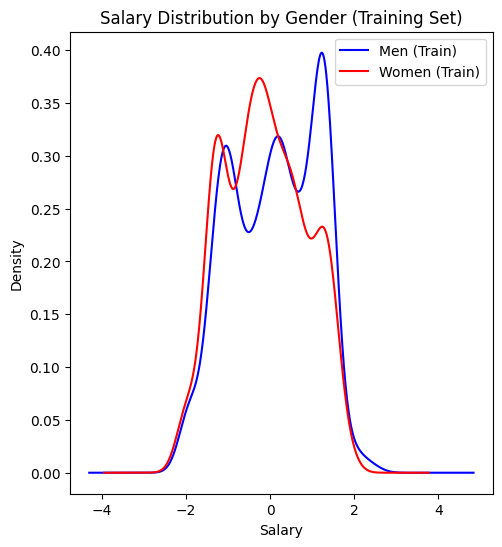

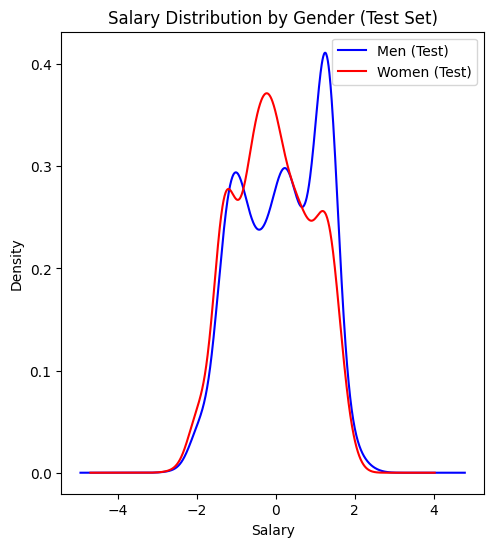

In [102]:
import matplotlib.pyplot as plt

# Separate the data by gender in the training set
train_salaries_men = train[train['Gender'] == 0]['Salary']
train_salaries_women = train[train['Gender'] == 1]['Salary']

# Separate the data by gender in the test set
test_salaries_men = test[test['Gender'] == 0]['Salary']
test_salaries_women = test[test['Gender'] == 1]['Salary']

# Plot the salary distributions for men and women in the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_salaries_men.plot(kind='density', label='Men (Train)', color='blue')
train_salaries_women.plot(kind='density', label='Women (Train)', color='red')
plt.title('Salary Distribution by Gender (Training Set)')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()

# Plot the salary distributions for men and women in the test set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
test_salaries_men.plot(kind='density', label='Men (Test)', color='blue')
test_salaries_women.plot(kind='density', label='Women (Test)', color='red')
plt.title('Salary Distribution by Gender (Test Set)')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()

Diffrence in mean salary for all jobs

In [95]:
mean_salary_men-mean_salary_women

10300.295165969903

Diffrence in mean salary prediction for all jobs

In [96]:
selected_features = ['Years of Experience', 'Education Level', 'Age', 'Gender','Job Title']
predictions = model_all_gen.predict(X_test[selected_features])
predictions = pd.Series(predictions, index=test.index)
sensitive_atribute = test[sensitive_feature]

In [97]:
predictions

2827    0.967791
2269   -0.997911
1313    0.993644
2769   -0.564929
5714   -0.243195
          ...   
1945    1.264729
4268   -1.123822
3031   -0.830638
4496   -1.679461
5884   -1.293294
Length: 1812, dtype: float64

In [100]:
# Predict salaries for men and women using the trained model
predictions = model_all_gen.predict(X_test[selected_features])
predictions = pd.Series(predictions, index=test.index)

# Separate the predictions by gender
predictions_men = predictions[sensitive_atribute['Gender'] == 0]
predictions_women = predictions[sensitive_atribute['Gender'] == 1]


sum_error_all = 0

for i, pred in enumerate(predictions_men):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
print(f"Mean Predicted Salary for Men: {sum_error_all:.2f}")
mean_predicted_salary_men = sum_error_all
sum_error_all = 0

for i, pred in enumerate(predictions_women):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
print(f"Mean Predicted Salary for Women: {sum_error_all:.2f}")
mean_predicted_salary_women = sum_error_all

print(f"Diffrence in mean salary prediction for all jobs: {mean_predicted_salary_men-mean_predicted_salary_women:.2f}")

Mean Predicted Salary for Men: 70334.92
Mean Predicted Salary for Women: 58549.62
Diffrence in mean salary prediction for all jobs: 11785.30


# Is Uni worth it?

In [ ]:
## The idea is to see if 4 years of experience is worth more than a Bachelor or 6 years more than a Master's or 10 years more than a PhD

model_all